In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum


import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d


np.random.seed(1209432)

# Dead time - white noise case
Here we show that the difference of Fourier amplitudes is _not_ independent of frequency when dead time is presence, but still _independent from the correlated noise_. Therefore, this dependence is **exactly the same that we want to eliminate from the Power spectrum, but in this case it is not affected by the signal.**

In [2]:

length = 1000
whitenoise_ev_1 = np.sort(np.random.uniform(0, length, 2000000))
whitenoise_ev_2 = np.sort(np.random.uniform(0, length, 2000000))

lc1 = Lightcurve.make_lightcurve(whitenoise_ev_1, gti=[[0, length]], tstart=0, tseg=length, dt=1/4096)
lc2 = Lightcurve.make_lightcurve(whitenoise_ev_2, gti=[[0, length]], tstart=0, tseg=length, dt=1/4096)

# plt.figure(figsize=(10, 5))

lc1_rough = Lightcurve.make_lightcurve(whitenoise_ev_1, gti=[[0, length]], tstart=0, tseg=length, dt=0.3)
# plt.plot(lc1_rough.time, lc1_rough.counts, lw=1, color='k', label='No dead time')

cs = Crossspectrum(lc1, lc2, norm="leahy")
pds = Powerspectrum(lc1, norm="leahy")

wn_ev_1_dt = filter_for_deadtime(whitenoise_ev_1, 2.5e-3)
wn_ev_2_dt = filter_for_deadtime(whitenoise_ev_2, 2.5e-3)

print(wn_ev_1_dt)
lc1 = Lightcurve.make_lightcurve(wn_ev_1_dt, gti=[[0, length]], tstart=0, tseg=length, dt=1/4096)
lc2 = Lightcurve.make_lightcurve(wn_ev_2_dt, gti=[[0, length]], tstart=0, tseg=length, dt=1/4096)
print(len(lc1), len(lc2))

lc1_rough = Lightcurve.make_lightcurve(wn_ev_1_dt, gti=[[0, length]], tstart=0, tseg=length, dt=0.3)


[ 1.5914225e-05  0.0026343683  0.005285453 ...,  999.99274  999.99538
  999.99852]
4096000 4096000


<IPython.core.display.Javascript object>


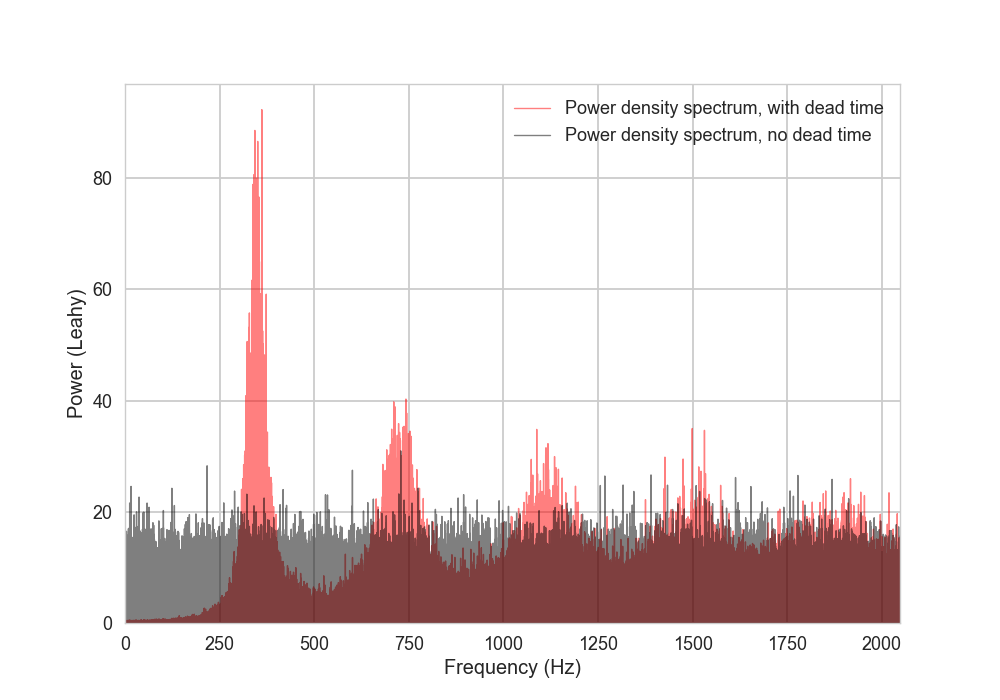

In [3]:
cs_dt = Crossspectrum(lc1, lc2, norm="leahy")
pds1_dt = Powerspectrum(lc1, norm="leahy")
pds2_dt = Powerspectrum(lc2, norm="leahy")
pds_dt = copy.copy(pds1_dt)
pds_dt.m = 2 * pds_dt.m
pds_dt.power = (pds1_dt.power + pds2_dt.power) / 2

fig, ax1 = plt.subplots(1, 1, figsize=(10,7))
ax1.plot(pds1_dt.freq, pds1_dt.power, color='r', alpha=0.5, lw=1, label='Power density spectrum, with dead time')
ax1.plot(pds.freq, pds.power, color='k', alpha=0.5, lw=1, label='Power density spectrum, no dead time')

ax1.legend()
ax1.set_ylabel('Power (Leahy)')

ax1.set_xlabel('Frequency (Hz)')
ax1.set_xlim([0, 2048])
ax1.set_ylim([0, None])
plt.savefig('pds_dt.jpg')

<IPython.core.display.Javascript object>


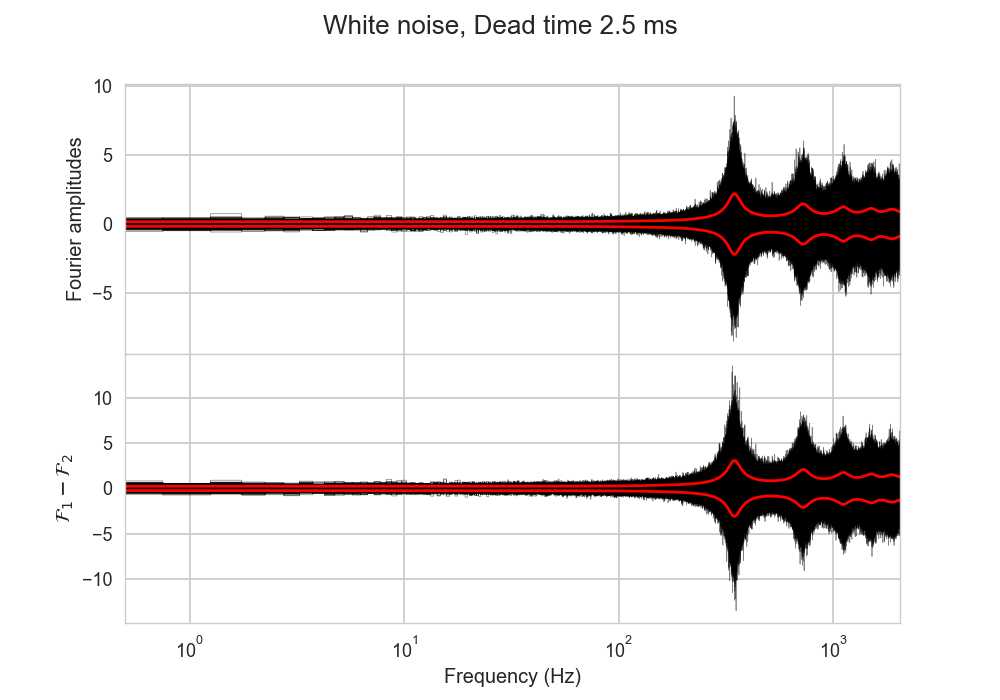

In [4]:
plt.figure(figsize=(10, 7))
plt.suptitle("White noise, Dead time 2.5 ms")
gs = GridSpec(2, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

fourier_all = []
diff_all = []
for start_time in np.arange(lc1.time[0], lc1.time[-1], 2):
    good = (lc1.time >= start_time)&(lc1.time < start_time + 2)
    good_counts1 = lc1.counts[good]
    good_counts2 = lc2.counts[good]
    
    fourier1 = scipy.fftpack.fft(good_counts1)
    fourier2 = scipy.fftpack.fft(good_counts2)

    freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

    fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
    fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))
    freqs = freqs[freqs > 0]

    ax0.plot(freqs, fourier1.real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, fourier2.real, drawstyle='steps-mid', color='r', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, gaussian_filter1d(np.sqrt(fourier2 * fourier1.conj()).real, 10), lw=1)
    ax0.semilogx()
    fourier_all.append(fourier1.real)
    
    ax1.plot(freqs, (fourier1 - fourier2).real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
    diff_all.append((fourier1 - fourier2).real)

fourier_all = np.array(fourier_all)
diff_all = np.array(diff_all)

ax0.plot(freqs, gaussian_filter1d(np.std(fourier_all, axis=0), 10), lw=2, color='r')
ax0.plot(freqs, -gaussian_filter1d(np.std(fourier_all, axis=0), 10),  lw=2, color='r')
ax0.set_ylabel('Fourier amplitudes')

ax1.plot(freqs, gaussian_filter1d(np.std(diff_all, axis=0), 10), lw=2, color='r')
ax1.plot(freqs, -gaussian_filter1d(np.std(diff_all, axis=0), 10), lw=2, color='r')
ax1.set_ylabel('$\mathcal{F}_1 - \mathcal{F}_2$')


ax1.set_xlabel('Frequency (Hz)')
ax0.set_xlim(freqs[0], freqs[-1])

plt.savefig('rn_fourierdiff_dt.jpg')



<IPython.core.display.Javascript object>


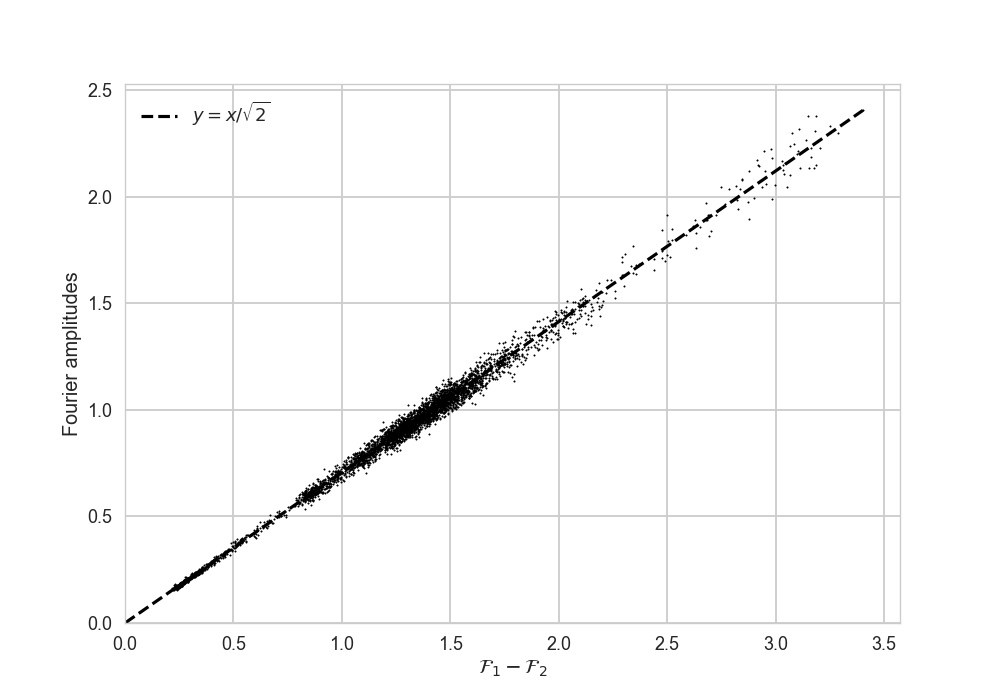

In [5]:
plt.figure(figsize=(10, 7))

stddiff = np.std(diff_all, axis=0)
stdfour = np.std(fourier_all, axis=0)
plt.scatter(stddiff, stdfour, s=1, c='k')

plt.plot(np.linspace(0, np.max(stddiff), 1000), 
         np.linspace(0, np.max(stddiff), 1000) / 2 ** 0.5, 
         'k--', label=r'$y = x / \sqrt{2}$')
plt.ylabel('Fourier amplitudes')
plt.xlabel('$\mathcal{F}_1 - \mathcal{F}_2$')

plt.legend()
# plt.set_ylabel('$\mathcal{F}_1 - \mathcal{F}_2$')
plt.xlim([0, None])
plt.ylim([0, None])

plt.savefig('fourier_vs_diff_dt.jpg')

[  1.22070312e-04   3.66210938e-04   6.10351562e-04 ...,   9.99999390e+02
   9.99999634e+02   9.99999878e+02]


<IPython.core.display.Javascript object>


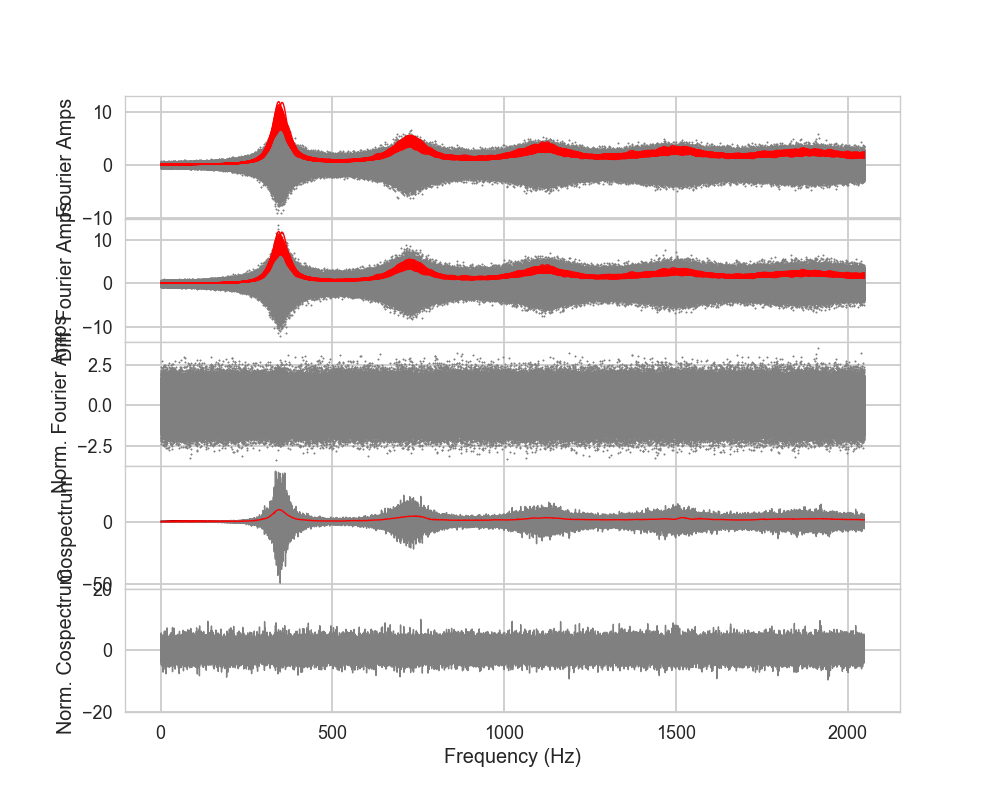

In [6]:
from matplotlib.gridspec import GridSpec
print(lc1.time)

plt.figure(figsize=(10, 8))
plt.title("Dead time")
gs = GridSpec(5, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)
ax3 = plt.subplot(gs[3], sharex=ax0)
ax4 = plt.subplot(gs[4], sharex=ax0)

hist_cosp = 0
hist_cosp_dt = 0
hist_pds = 0
hist_pds_dt = 0

count = 0
bins_cosp = np.arange(-50, 50, 0.01)
bins_pds = np.arange(-10, 100, 0.01)

for start_time in np.arange(lc1.tstart, lc1.tseg, 5):
    good = (lc1.time > start_time)&(lc1.time < start_time + 5)
    good_counts1 = lc1.counts[good]
    good_counts2 = lc2.counts[good]

    fourier1 = scipy.fftpack.fft(good_counts1)
    fourier2 = scipy.fftpack.fft(good_counts2)

    freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

    fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
    fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))

    freqs = freqs[freqs > 0]

    smooth_real = gaussian_filter1d(((fourier1 - fourier2)).real**2, 50)

    # First panel: Amplitudes
    ax0.set_ylabel('Fourier Amps')
    ax0.scatter(freqs, fourier1.real, s=1, c='grey')
    ax0.scatter(freqs, fourier2.real, s=1, c='grey')
    ax0.plot(freqs, smooth_real, lw=1, color='red')

    # Second panel: Difference amplitudes
    ax1.set_ylabel('Diff. Fourier Amps')

    ax1.scatter(freqs, (fourier1 - fourier2).real, s=1, c='grey')
    ax1.plot(freqs, smooth_real, lw=1, color='red')

    # Third panel: Normalized amplitudes
    ax2.set_ylabel('Norm. Fourier Amps')
    ax2.scatter(freqs, fourier1.real / smooth_real ** 0.5, s=1, c='grey')

    # Fourth panel: Unnormalized cospectrum
    ax3.set_ylabel('Cospectrum')

    ax3.plot(freqs, (fourier1 * fourier2.conj()).real, drawstyle='steps-mid', 
             label='Unnormalized', lw=1, zorder= 10, color='grey')
    ax3.plot(freqs, smooth_real, lw=1, color='red', zorder=10)


    # Fifth panel: Normalized cospectrum
    ax4.set_ylabel('Norm. Cospectrum')

    ax4.plot(freqs, (fourier1 * fourier2.conj()).real / smooth_real * 2 ** 0.5, drawstyle='steps-mid', 
             label='Ratio by smoothed difference', lw=1, zorder= 10, color='grey')


    ax4.set_ylim([-20, 20])
    ax4.set_xlabel('Frequency (Hz)')
#     plt.legend()
    hist_cosp += np.histogram((fourier1 * fourier2.conj()).real / smooth_real * 2, 
                         bins=bins_cosp, normed=True)[0]
    hist_cosp_dt += np.histogram((fourier1 * fourier2.conj()).real, 
                         bins=bins_cosp, normed=True)[0]

    hist_pds += np.histogram((fourier1 * fourier1.conj()) / smooth_real * 2, 
                         bins=bins_pds, normed=True)[0]
    hist_pds_dt += np.histogram((fourier1 * fourier1.conj()), 
                                bins=bins_pds, normed=True)[0]



    count += 1

hist_cosp = hist_cosp / count
hist_cosp_dt = hist_cosp_dt / count

hist_pds = hist_pds / count
hist_pds_dt = hist_pds_dt / count

<IPython.core.display.Javascript object>


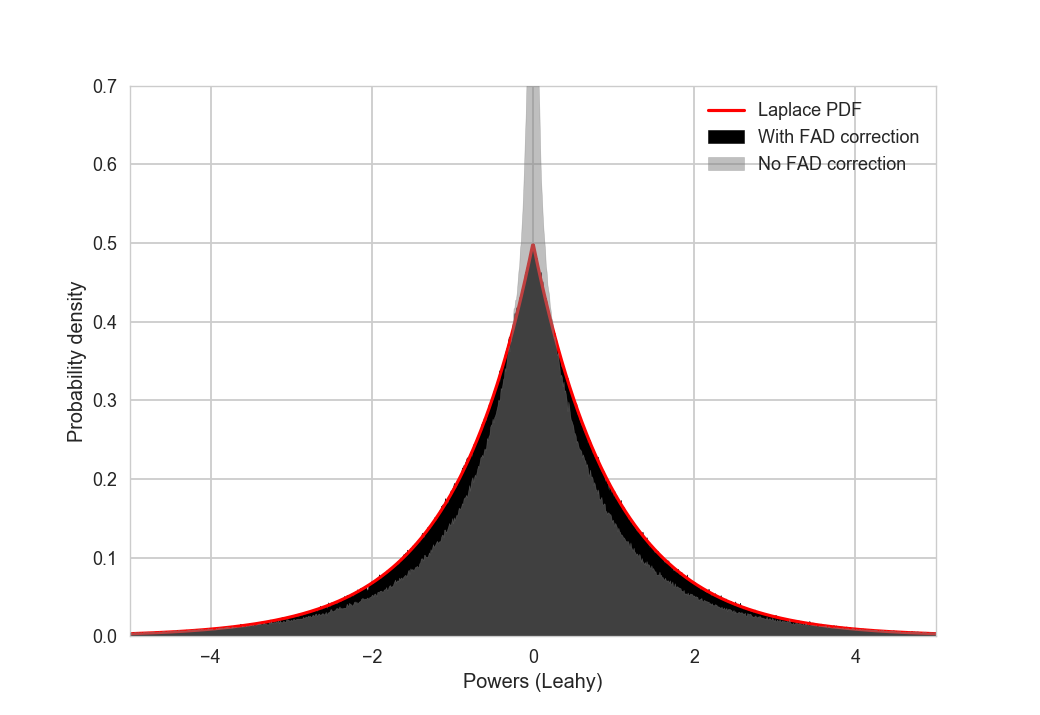

<IPython.core.display.Javascript object>


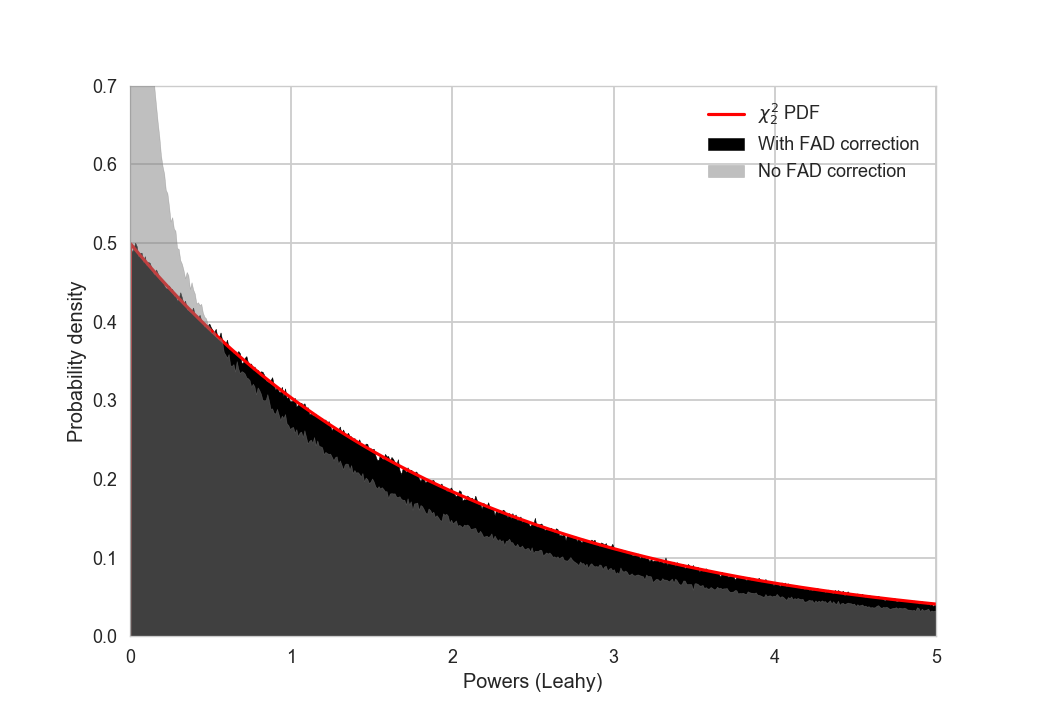

In [7]:
u = np.linspace(-50, 50, 10000)

lapl = scipy.stats.laplace(0, 1)
lapl_prob = lapl.pdf(u)

plt.figure()
plt.fill(bins_cosp[:-1] + 0.005, hist_cosp, label='With FAD correction', color='k')
plt.fill(bins_cosp[:-1] + 0.005, hist_cosp_dt, alpha=0.5, label='No FAD correction', color='grey', zorder=3)

plt.plot(u, lapl_prob, label='Laplace PDF', color='r')
plt.xlim([-5, 5])
plt.ylim([0, 0.7])
plt.legend()
plt.xlabel('Powers (Leahy)')
plt.ylabel('Probability density')



plt.savefig('cosp_pdf.jpg')


plt.figure()
u = np.linspace(-10, 50, 10000)
chisq = scipy.stats.chi2(2)
chisq_prob = chisq.pdf(u)


plt.fill(bins_pds[:-1] + 0.005, hist_pds, label='With FAD correction', color='k')
plt.fill(bins_pds[:-1] + 0.005, hist_pds_dt, alpha=0.5, label='No FAD correction', color='grey', zorder=3)


plt.plot(u, chisq_prob, label='$\chi^2_2$ PDF', color='r')
plt.xlabel('Powers (Leahy)')
plt.ylabel('Probability density')

plt.legend()
plt.xlim([0, 5])
plt.ylim([0, 0.7])
plt.savefig('pds_pdf.jpg')
